In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.fft import fft


def calculate_lyapunov_exponent(x, y, t):
    distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    log_distances = np.log(distances + 1e-10)
    time_diffs = np.diff(t)
    return np.mean(log_distances / (time_diffs + 1e-10))
        

def calculate_spectral_entropy(signal, sampling_rate=1):
    try:
        power_spectrum = np.abs(np.fft.fft(signal))**2
        power_spectrum /= np.sum(power_spectrum)
        spectral_entropy = -np.sum(power_spectrum * np.log2(power_spectrum + 1e-10))
        return spectral_entropy
    except Exception as e:
        return 0.0

def calculate_dominant_frequency(signal, sampling_rate=1):
    try:
        fft_vals = np.fft.fft(signal)
        fft_freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)
        positive_freqs = fft_freqs[fft_freqs > 0]
        positive_amplitudes = np.abs(fft_vals[fft_freqs > 0])
        dominant_freq = positive_freqs[np.argmax(positive_amplitudes)] if len(positive_freqs) > 0 else 0.0
        return dominant_freq
    except Exception as e:
        return 0.0


def validate_input_lengths(x, y, t):
    if len(x)<len(t):
        n=len(t)-len(x)
        t = t[:len(t)-n]
        return {'x':x,'y':y,'t':t}
    if len(x)>len(t):
        n=len(x)-len(t)
        t.extend([t[-1]]*n)
        return {'x':x,'y':y,'t':t}
    return {'x':x,'y':y,'t':t}


def calculate_features_for_segment(segment):
    x,y,t = segment[0],segment[1],segment[2]
    valid=validate_input_lengths(x, y, t)
    x,y,t=valid['x'],valid['y'],valid['t']
    
    total_distance = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
    linear_distance = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
    linearity = linear_distance / total_distance if total_distance > 0 else 0

    distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    time_diffs = np.diff(t)

    with np.errstate(divide='ignore', invalid='ignore'):
        velocities = np.where(time_diffs > 0, distances / time_diffs, 0)
    velocity_variance = np.var(velocities) if len(velocities) > 0 else 0

    lyapunov_exponent=calculate_lyapunov_exponent(x,y,t)
    dominant_frequency=calculate_dominant_frequency(velocities)
    spectral_entropy=calculate_spectral_entropy(velocities)

    features = {
        "linearity": linearity,
        "velocity_variance": velocity_variance,
        "lyapunov_exponent": lyapunov_exponent,
        "dominant_frequency": dominant_frequency,
        "spectral_entropy": spectral_entropy
    }
    return features


def calculate_features_for_trajectory(mtb,times):
    x=[[int(i.split('(')[1].split(',')[0]) for i in re.findall("m[(][0-9,]*[)]",j)] for j in re.split("c.?[(][0-9,]*[)]",mtb)]
    y=[[int(i.split(',')[1].split(')')[0]) for i in re.findall("m[(][0-9,]*[)]",j)] for j in re.split("c.?[(][0-9,]*[)]",mtb)]
    t=[int(x) for x in times.split(',')[:-1]]

    for i in range(len(x)-1):
        t.pop(sum([len(x[j]) for j in range(i+1)]))

    segments=[]

    for i,segment in enumerate(x):
        t_segment=t[:len(segment)]
        del t[:len(segment)]
        segments.append((segment,y[i],t_segment))
            
    segment_features = [calculate_features_for_segment(segment) for segment in segments if len(segment[0])>49]

    trajectory_features = {
        key: np.mean([segment[key] for segment in segment_features])
        for key in segment_features[0]
    }
    return trajectory_features



In [3]:
human_df = pd.read_json(r'.\web_bot_detection_dataset\phase2\data\mouse_movements\humans\mouse_movements_humans.json',lines=True)
abot_df = pd.read_json(r'.\web_bot_detection_dataset\phase2\data\mouse_movements\bots\mouse_movements_advanced_bots.json',lines=True)
mbot_df = pd.read_json(r'.\web_bot_detection_dataset\phase2\data\mouse_movements\bots\mouse_movements_moderate_bots.json',lines=True)

In [5]:
human_df["label"]="human"
abot_df["label"]="abot"
mbot_df["label"]="mbot"

In [7]:
df=pd.concat([human_df, abot_df, mbot_df], axis=0,ignore_index=True)

In [9]:
df[["linearity","velocity_variance","lyapunov_exponent","dominant_frequency","spectral_entropy"]] = df.apply(lambda row: calculate_features_for_trajectory(row['mousemove_total_behaviour'],row['mousemove_times']), axis='columns', result_type='expand')

In [11]:
df2 = df[["label","linearity","velocity_variance","lyapunov_exponent","dominant_frequency","spectral_entropy"]].copy()
df2

,label,linearity,velocity_variance,lyapunov_exponent,dominant_frequency,spectral_entropy
0,human,0.182284,3.122532,1.007327e+06,0.013479,5.340414
1,human,0.309099,1.575993,9.434826e-02,0.017807,4.698666
2,human,0.300515,0.811506,9.845944e-02,0.018041,4.455769
3,human,0.283754,0.712525,8.615286e-02,0.009835,5.318289
4,human,0.236739,1.459108,3.705717e+06,0.010132,5.079366
...,...,...,...,...,...,...
294,mbot,0.963785,0.000231,-4.277230e-03,0.283867,0.638320
295,mbot,0.959240,0.000254,-3.574395e-03,0.254628,0.644671
296,mbot,0.959089,0.000212,-1.815912e-03,0.264890,0.555757
297,mbot,0.967850,0.000169,-2.609294e-03,0.228688,0.497145


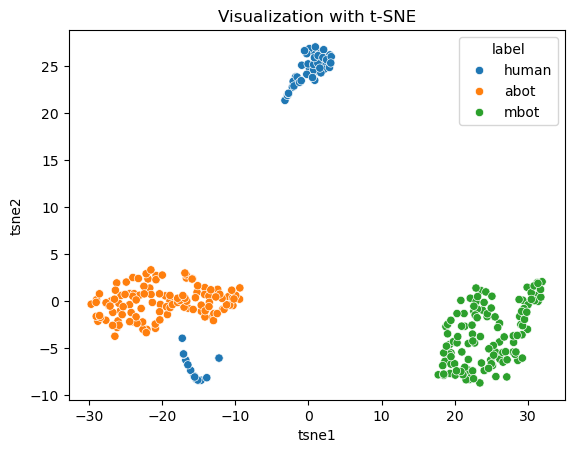

In [13]:
import seaborn as sns
features = df2.columns.difference(['label'])

X = df2[features]
y = df2['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df2['tsne1'] = tsne_result[:, 0]
df2['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df2)
plt.title('Visualization with t-SNE')
plt.show()

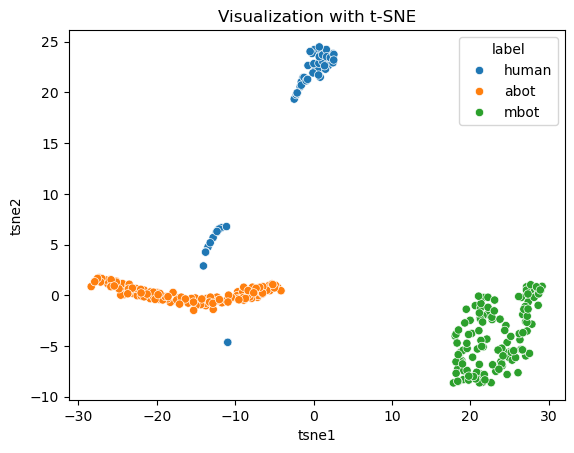

In [15]:
df3 = df[["label","velocity_variance","lyapunov_exponent","dominant_frequency","spectral_entropy"]].copy()

features = df3.columns.difference(['label'])

X = df3[features]
y = df3['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df3['tsne1'] = tsne_result[:, 0]
df3['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df3)
plt.title('Visualization with t-SNE')
plt.show()

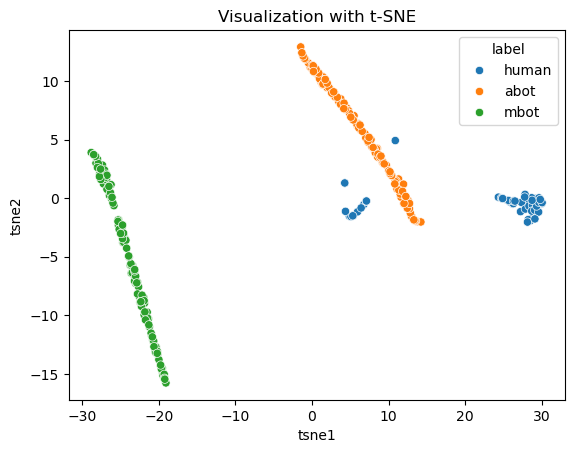

In [17]:
df4 = df[["label","velocity_variance","lyapunov_exponent","spectral_entropy"]].copy()

features = df4.columns.difference(['label'])
X = df4[features]
y = df4['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df4['tsne1'] = tsne_result[:, 0]
df4['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df4)
plt.title('Visualization with t-SNE')
plt.show()

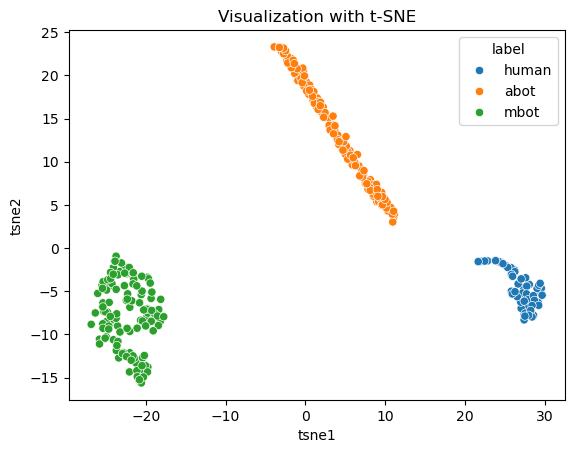

In [19]:
df5 = df[["label","velocity_variance","dominant_frequency","spectral_entropy"]].copy()

features = df5.columns.difference(['label'])
X = df5[features]
y = df5['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df5['tsne1'] = tsne_result[:, 0]
df5['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df5)
plt.title('Visualization with t-SNE')
plt.show()

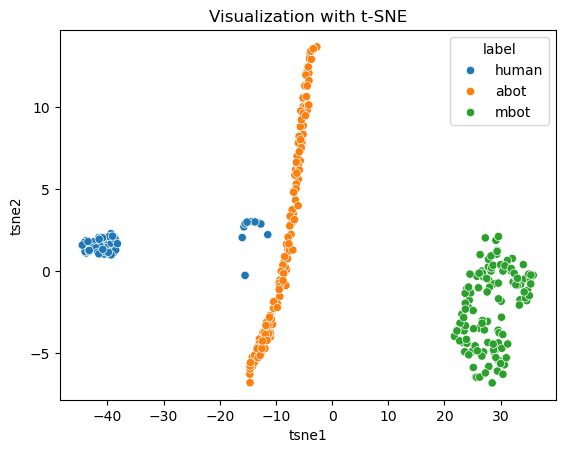

In [21]:
df6 = df[["label","lyapunov_exponent","dominant_frequency","spectral_entropy"]].copy()

features = df6.columns.difference(['label'])
X = df6[features]
y = df6['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df6['tsne1'] = tsne_result[:, 0]
df6['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df6)
plt.title('Visualization with t-SNE')
plt.show()